# Synexpression groups identification - Pearson Corrilation

ID: 

Name: Iris Milligan

Last modified: 03.05.2021

## Required Libraries

In [1]:
import pandas as pd
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex, colorConverter
from mpl_toolkits.mplot3d import Axes3D


In [63]:
def print_output_to_file(file_name, data_to_save, sheetName, method):
    # Print output to confirm data format
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    # writer = pd.ExcelWriter(file_name, engine='xlsxwriter', mode=method)
    writer = pd.ExcelWriter(file_name, engine="openpyxl", mode=method)
    # Convert the dataframe to an XlsxWriter Excel object.
    data_to_save.to_excel(writer, sheet_name=sheetName)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()

In [2]:
# Open File to Process
rawdata = pd.read_table("TomoZF10ss.csv",delimiter = ',')

In [3]:
# Import external data
# convert data type

# Mapping ENSEMBL back to GENE name to help label and search operations 
gene_mapping = rawdata
gene_mapping.index = gene_mapping['ENSEMBL']
gene_mapping = gene_mapping[gene_mapping.columns[1:2]]
gene_mapping = gene_mapping.fillna(0)

# now loop through the mapping and convert any gene names = 0 to the ensemble
for row_num, value in enumerate(gene_mapping.index.values):
    if(gene_mapping.iloc[row_num][0]==0):
        gene_mapping.iloc[row_num,0] = value 
    
# set index
rawdata.index = rawdata['ENSEMBL'] 
rawdata = rawdata.drop(['ENSEMBL','gene','name'], axis=1)

# Have to drop Rows where the Gene name aka(index) is Blank
# data = data.loc[data.index.dropna(how='all')]
# To Follow Spactial DB we convert NaN to 0
rawdata = rawdata.fillna(0)

# need to capture row 0 into a list for mapping later as column names
section_map = rawdata.columns.tolist()

## Now cut the data into the different groups AP, LR and VD

In [76]:
# subset gene

data = rawdata[rawdata.columns[0:51]]
APdata = rawdata[rawdata.columns[0:52]]
LRdata = rawdata[rawdata.columns[52:104]]
VDdata = rawdata[rawdata.columns[104:156]]

# Rename Columns so they align for future plotting.
LRdata.columns=APdata.columns
VDdata.columns=APdata.columns

#Remove Duplicate Columns
APdata = APdata.loc[:,~APdata.columns.duplicated()]
LRdata = LRdata.loc[:,~LRdata.columns.duplicated()]
VDdata = VDdata.loc[:,~VDdata.columns.duplicated()]

In [59]:
### Create Pearson Correlation 
rawdataT = rawdata.T
pairwise = rawdataT.corr()
pairwise.columns = gene_mapping['gene'].to_list()
pairwise.index = gene_mapping['gene'].to_list()

# Specify Gene to look at
geneID = "etv2"
#Testing on ENSDARG00000052402
temp = pairwise[[geneID]]
temp = temp.sort_values(by=geneID,ascending=False)
print(temp.head(n=20))

                     etv2
etv2             1.000000
sox7             0.890672
tal1             0.871441
hbae1            0.830254
lmo2             0.808792
hbbe1.1          0.805112
clec14a          0.795690
hbae3            0.794660
hbbe3            0.790296
egfl7            0.786248
blf              0.761346
anxa4            0.759434
fli1a            0.755740
elk3             0.754882
dre-mir-126b     0.753607
aplnra           0.732924
tpm4a            0.720982
etnk1            0.710183
phlda2           0.704472
si:dkey-52l18.4  0.698794


In [74]:
# Build Output list with EnsembleID
i = 0
# Create DataFrame for output
outputPD = pd.DataFrame(columns=["Ensemble","Gene","P-Value"])

while i < 20:
    for row_num, value in enumerate(gene_mapping.index.values):
        if(gene_mapping.iloc[row_num][0]==temp.index.values[i]):
            es1 = value
    outputPD = outputPD.append({'Ensemble' : es1,'Gene' : temp.index.values[i],'P-Value' : temp.values[i]},ignore_index=True)
    i=i+1

# Write to out put file and append s eet: sheetname equal geneID
print_output_to_file("PearOutputbyGene.xlsx",outputPD,geneID,"a")

## Build Line Plots

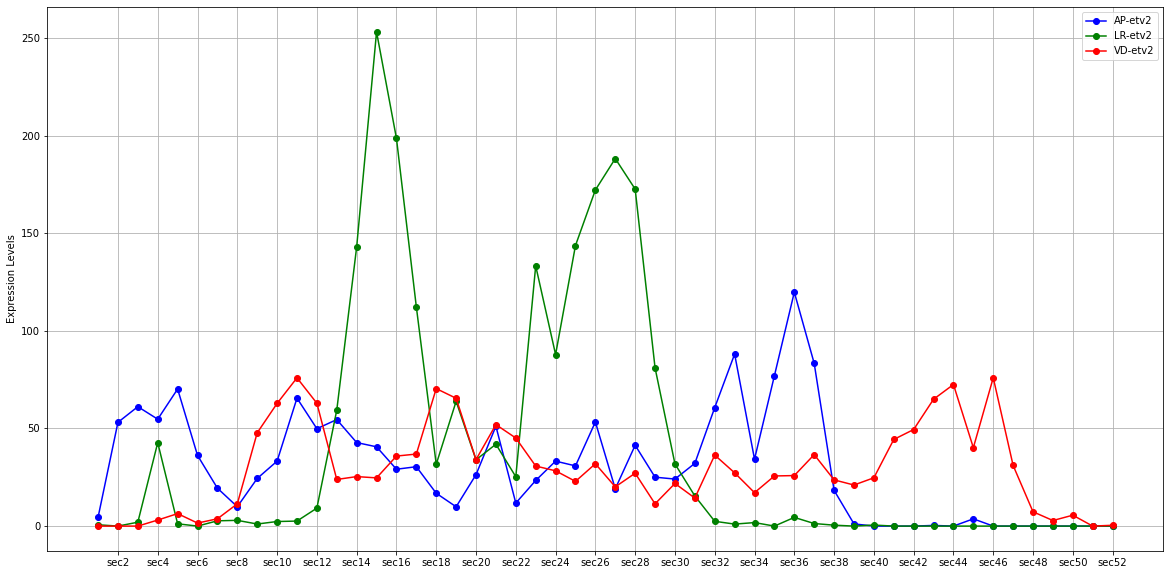

In [77]:
# Generate LinePlot to compare with SpatialDB
ensemblID = gene_mapping.loc[gene_mapping['gene']==geneID]

# Need to build dataframe from AP, LR and VD dataframes to use for Multi-Line plot
lineDF = pd.DataFrame(columns=APdata.columns)
lr1 = pd.DataFrame(columns=APdata.columns)
vd1 = pd.DataFrame(columns=APdata.columns)
lensemb_value=ensemblID.index.values

# Find gene in each of the 3 DataFrames
lineDF=APdata.loc[lensemb_value,:]
lr1=LRdata.loc[lensemb_value,:]
vd1=VDdata.loc[lensemb_value,:]

# Now append results into 1 DataFrame
lineDF=lineDF.append(lr1,ignore_index=False)
lineDF=lineDF.append(vd1,ignore_index=False)

# Transpose ne DataFrame
lineDFT = lineDF.T

# Set Labels
lineDFT.columns=['AP-'+geneID,'LR-'+geneID,'VD-'+geneID]

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
markers=['o','d','s']
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list,color=["blue","green","red"],marker='o', ylabel="Expression Levels")
plt.show()

## Build line plots for the AP, LR and VD represemntations of the top genes for fgf17

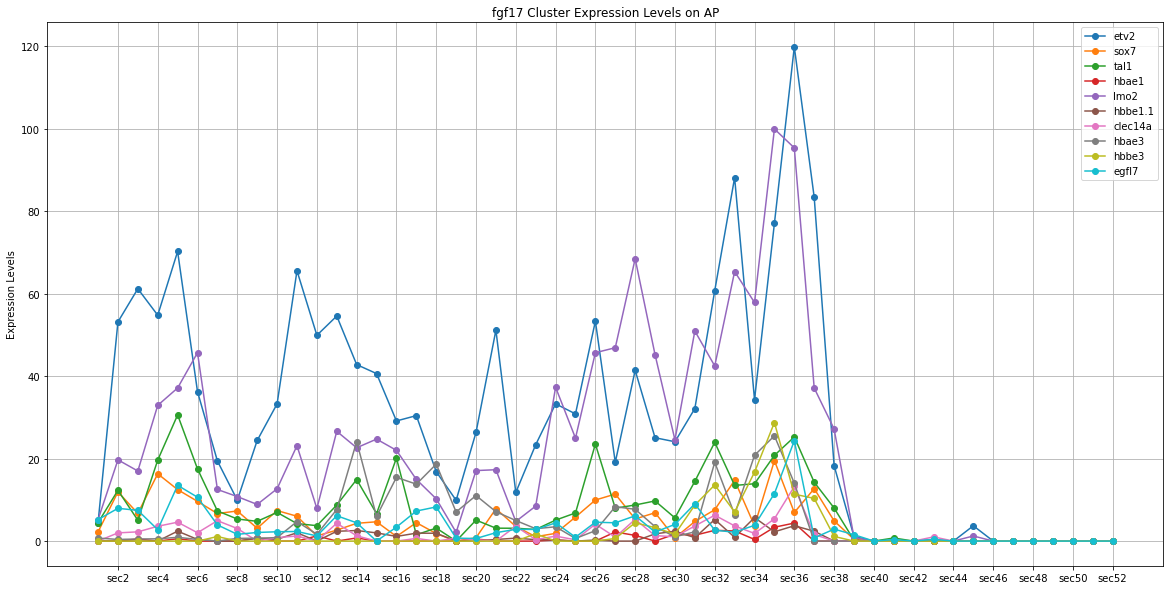

In [82]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
APdata.index = gene_mapping['gene'].to_list()

APdataT = APdata.T
lineDF = pd.DataFrame(columns=APdata.columns)

while i < 10:
    geneID = plotgenes[i]
    lineDF = lineDF.append(APdata.loc[geneID],ignore_index=False)
    i = i+1    

# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title="fgf17 Cluster Expression Levels on AP")
plt.show()

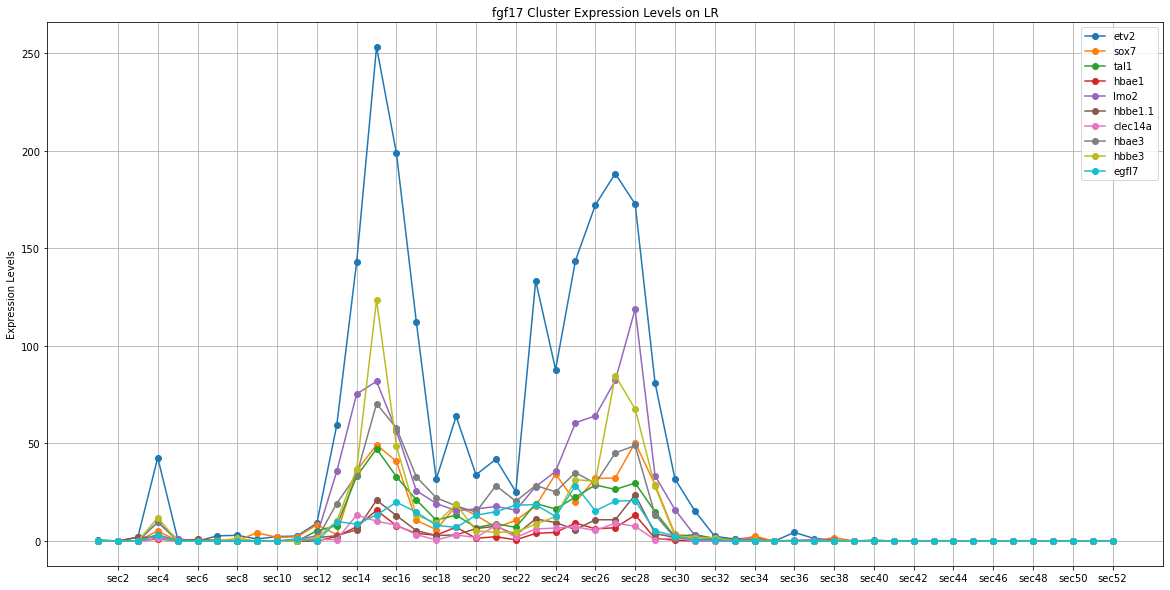

In [80]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
LRdata.index = gene_mapping['gene'].to_list()

LRdataT = LRdata.T
lineDF = pd.DataFrame(columns=LRdata.columns)

while i < 10:
    geneID = plotgenes[i]
    lineDF = lineDF.append(LRdata.loc[geneID],ignore_index=False)
    i = i+1    


# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title="fgf17 Cluster Expression Levels on LR")
plt.show()

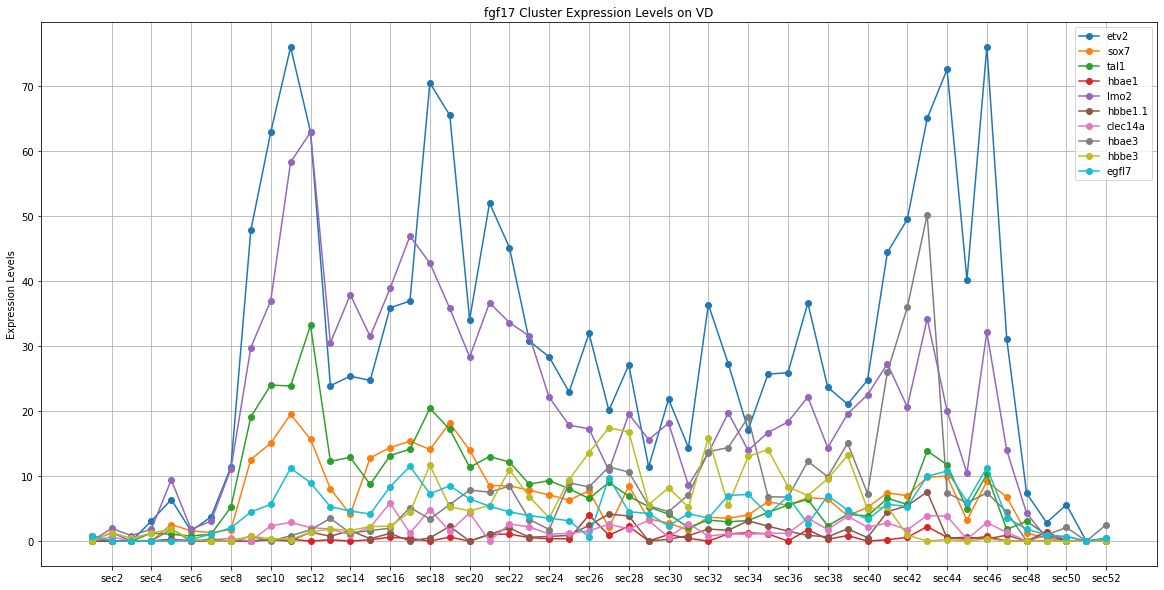

In [81]:
# Generate LinePlot to compare with SpatialDB
plotlist = temp.index.to_list()
plotgenes = plotlist[:10]

# Loop through list and build data for line plot
i = 0
VDdata.index = gene_mapping['gene'].to_list()

VDdataT = VDdata.T
lineDF = pd.DataFrame(columns=VDdata.columns)

while i < 10:
    geneID = plotgenes[i]
    lineDF = lineDF.append(VDdata.loc[geneID],ignore_index=False)
    i = i+1    

# Transpose ne DataFrame
lineDFT = lineDF.T
# Remove Duplicate Columns
lineDFT = lineDFT.loc[:,~lineDFT.columns.duplicated()]
# Set Labels
lineDFT.columns=plotgenes

# Set frequency of x tick marks
p=0
xticks_label = pd.DataFrame(columns=['label'])
for col_num, value in enumerate(lineDFT.index.values):
    if(col_num%2):
        xticks_label.loc[p] = [value]
        p=p+1
        
# Set Tick Labels        
label_list = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
lineDFT.plot(figsize=(20,10),grid=True,xticks=label_list, marker='o', ylabel="Expression Levels",title="fgf17 Cluster Expression Levels on VD")
plt.show()